In [1]:
!pip install python-dateutil
!pip install pandas
!pip install GitPython

In [3]:
# getting all of the imports out of the way

import pandas as pd
import git
from io import StringIO
from dateutil.parser import parse

In [110]:
# alternative way to get all of the commit information potentially:

GIT_REPO_PATH = r'../repositories/big-bang'

repo = git.Repo(GIT_REPO_PATH, odbt=git.GitCmdObjectDB)

repo

commits = pd.DataFrame(repo.iter_commits('master'), columns=['raw'])
commits.head()

,raw
0,4c2a531567007909429bbe6840f69556c1b83772
1,488f89f27d38579be9fe1f6be677ba3e96b95f73
2,4989e8adf01ecd40016362e424b279c5e9b704d4
3,d8d05afdb8f43af607a30cf55475a35bbe9b65f3
4,11b3b19854f664968dcf58aac56079d123533a96


In [111]:
commits.shape[0]

4599

In [112]:
last_commit = commits.iloc[0]

last_commit['raw'].__slots__

('tree',
 'author',
 'authored_date',
 'author_tz_offset',
 'committer',
 'committed_date',
 'committer_tz_offset',
 'message',
 'parents',
 'encoding',
 'gpgsig')

In [113]:
commits['sha'] = commits['raw'].apply(lambda x: str(x))
commits['author'] = commits['raw'].apply(lambda x: x.author.name)
commits['committed_date'] = commits['raw'].apply(lambda x: pd.to_datetime(x.committed_datetime, utc=True))
commits['message'] = commits['raw'].apply(lambda x: x.message)
commits['parents'] = commits['raw'].apply(lambda x: x.parents)
commits['committer'] = commits['raw'].apply(lambda x: x.committer)

In [114]:
commits.head()

,raw,sha,author,committed_date,message,parents,committer
0,4c2a531567007909429bbe6840f69556c1b83772,4c2a531567007909429bbe6840f69556c1b83772,Ryan Garcia,2023-03-14 21:49:40+00:00,Merge branch 'enable-mtls-for-neuvector-metric...,"(4989e8adf01ecd40016362e424b279c5e9b704d4, 488...",Ryan Garcia
1,488f89f27d38579be9fe1f6be677ba3e96b95f73,488f89f27d38579be9fe1f6be677ba3e96b95f73,Brett Charrier,2023-03-14 21:49:40+00:00,Enable mTLS for Neuvector metrics\n,"(b7c7731260cb9993c8b437103e5e4f526bf70296,)",Ryan Garcia
2,4989e8adf01ecd40016362e424b279c5e9b704d4,4989e8adf01ecd40016362e424b279c5e9b704d4,Micah Nagel,2023-03-14 17:52:55+00:00,Merge branch 'update-kyverno-policies-tag-1.1....,"(11b3b19854f664968dcf58aac56079d123533a96, d8d...",Micah Nagel
3,d8d05afdb8f43af607a30cf55475a35bbe9b65f3,d8d05afdb8f43af607a30cf55475a35bbe9b65f3,mr-bot,2023-03-14 17:52:55+00:00,kyverno-policies update to 1.1.0-bb.3\n,"(ddd6e3eb73cec0bddee1ee224501e2f12cb35b08,)",Micah Nagel
4,11b3b19854f664968dcf58aac56079d123533a96,11b3b19854f664968dcf58aac56079d123533a96,Micah Nagel,2023-03-14 17:52:32+00:00,Merge branch 'update-kyverno-tag-2.6.5-bb.3' i...,"(15c82732e41ae61799da95dacfda9f826d8bb755, 5de...",Micah Nagel


In [117]:
import pandas as pd
import plotly.express as px

# grouping the commits by date since there are multiple for each date typically
commits_by_date = commits_by_date = commits.groupby('committed_date').size().reset_index(name='commit_count')

# commits_by_date

fig = px.bar(commits_by_date, x='committed_date', y='commit_count')
fig.update_traces(hovertemplate='Commits: %{y}<extra></extra>')
fig.update_layout(title='Number of Commits per Day')
fig.show()

In [83]:
import random

# understanding stats associated with a random commit

rand_commit = commits.iloc[random.randint(0, commits.shape[0])]['raw']

rand_commit.stats.files

{'chart/templates/kyverno/policies/values.yaml': {'insertions': 29,
  'deletions': 0,
  'lines': 29}}

In [84]:
# in order to make a stacked dataframe to later merge, we'll wrap a dataframe around a pandas series of the stats and call the stack() method

rand_commit_df = pd.DataFrame(pd.Series(rand_commit.stats.files)).stack()

In [85]:
stats = pd.DataFrame(commits['raw'].apply(lambda x: pd.Series(x.stats.files, dtype=object)).stack()).reset_index(level=1)
stats = stats.rename(columns={ 'level_1' : 'filename', 0 : 'stats_modifications'})
stats_modifications = stats['stats_modifications'].apply(lambda x: pd.Series(x))
stats = stats.join(stats_modifications)
del(stats['stats_modifications'])

In [86]:
stats.head()

,filename,insertions,deletions,lines
0,chart/templates/neuvector/values.yaml,9,2,11
0,chart/templates/neuvector/values.yaml,1,1,2
0,chart/values.yaml,9,2,11
0,chart/values.yaml,1,1,2
1,chart/templates/neuvector/values.yaml,9,2,11


In [87]:
commits = commits.join(stats)
del(commits['raw'])

commits.head()

,sha,author,committed_date,message,parents,committer,filename,insertions,deletions,lines
0,4c2a531567007909429bbe6840f69556c1b83772,Ryan Garcia,2023-03-14 21:49:40+00:00,Merge branch 'enable-mtls-for-neuvector-metric...,"(4989e8adf01ecd40016362e424b279c5e9b704d4, 488...",Ryan Garcia,chart/templates/neuvector/values.yaml,9.0,2.0,11.0
0,4c2a531567007909429bbe6840f69556c1b83772,Ryan Garcia,2023-03-14 21:49:40+00:00,Merge branch 'enable-mtls-for-neuvector-metric...,"(4989e8adf01ecd40016362e424b279c5e9b704d4, 488...",Ryan Garcia,chart/templates/neuvector/values.yaml,1.0,1.0,2.0
0,4c2a531567007909429bbe6840f69556c1b83772,Ryan Garcia,2023-03-14 21:49:40+00:00,Merge branch 'enable-mtls-for-neuvector-metric...,"(4989e8adf01ecd40016362e424b279c5e9b704d4, 488...",Ryan Garcia,chart/values.yaml,9.0,2.0,11.0
0,4c2a531567007909429bbe6840f69556c1b83772,Ryan Garcia,2023-03-14 21:49:40+00:00,Merge branch 'enable-mtls-for-neuvector-metric...,"(4989e8adf01ecd40016362e424b279c5e9b704d4, 488...",Ryan Garcia,chart/values.yaml,1.0,1.0,2.0
1,488f89f27d38579be9fe1f6be677ba3e96b95f73,Brett Charrier,2023-03-14 21:49:40+00:00,Enable mTLS for Neuvector metrics\n,"(b7c7731260cb9993c8b437103e5e4f526bf70296,)",Ryan Garcia,chart/templates/neuvector/values.yaml,9.0,2.0,11.0


In [88]:
commits.dtypes

sha                            object
author                         object
committed_date    datetime64[ns, UTC]
message                        object
parents                        object
committer                      object
filename                       object
insertions                    float64
deletions                     float64
lines                         float64
dtype: object

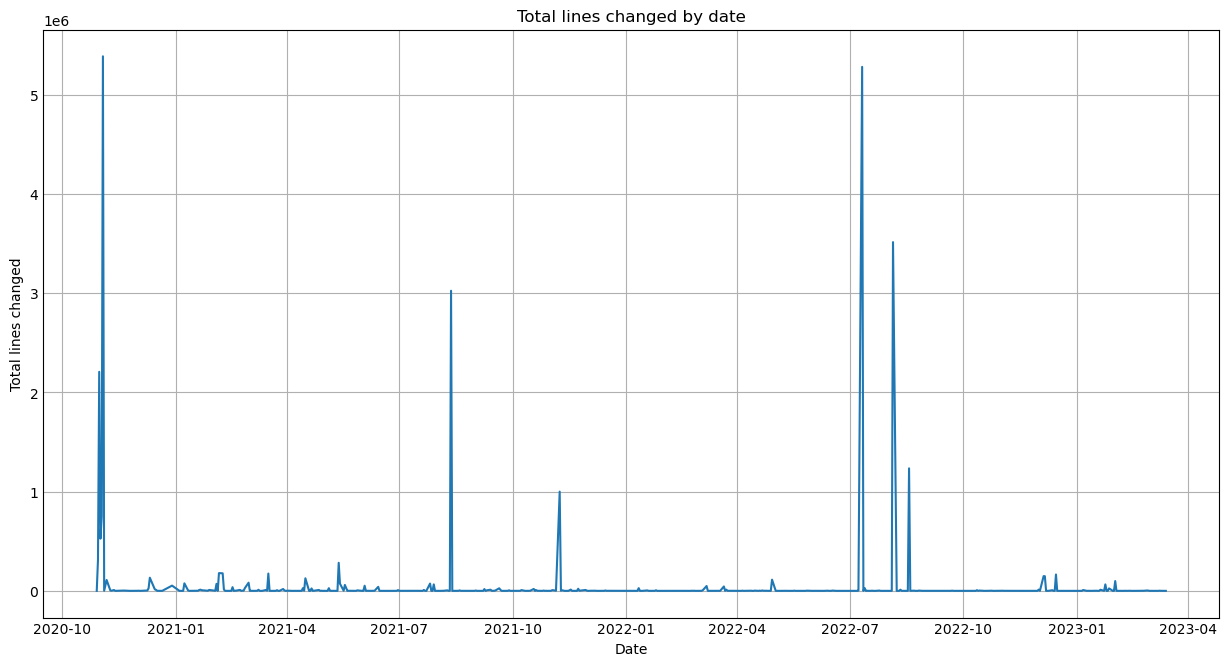

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors

# grouping the commits by date since there are multiple for each date typically
commits_by_date = commits.groupby(commits['committed_date'].dt.date).sum(numeric_only=True)
# grouping the lines changed (additions and deletions) by date
lines_by_date = commits.groupby(commits['committed_date'].dt.date)['lines'].sum(numeric_only=True)

# plotting the commit changes (lines) per grouped period
fig, ax = plt.subplots(figsize=(12, 6))  # Set the figure size to 12x6 inches
plt.style.use('_mpl-gallery')
plt.plot(commits_by_date.index, commits_by_date['lines'])
plt.xlabel('Date')
plt.ylabel('Total lines changed')
#plt.ylim(0, commits['lines'].max())
plt.title('Total lines changed by date')

def on_plot_hover(event):
    if event.inaxes is not None:
        x, y = event.xdata, event.ydata
        plt.annotate(commits_by_date.index[(commits_by_date['additions']==y).argmax()],
                     xy=(x, y), xytext=(0,10), textcoords='offset points')

plt.gcf().canvas.mpl_connect('motion_notify_event', on_plot_hover)

plt.show()

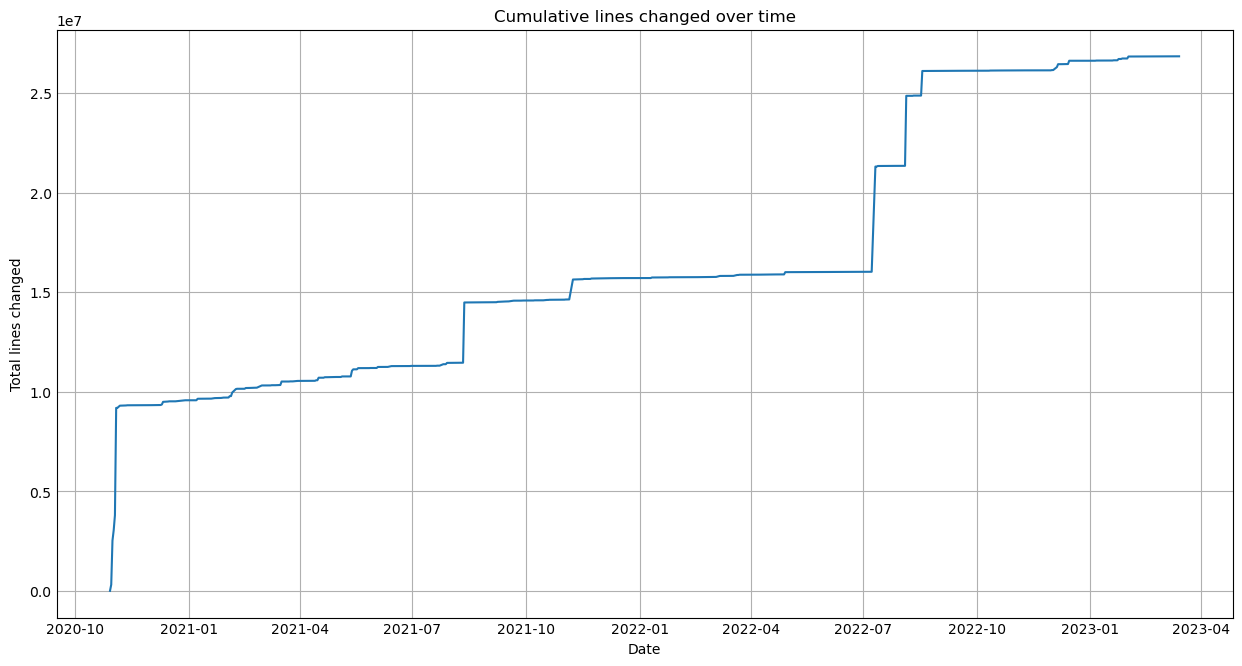

In [90]:
plt.figure(figsize=(12, 6))
plt.style.use('_mpl-gallery')

# grouping the commits by date since there are multiple for each date typically
commits_by_date = commits.groupby(commits['committed_date'].dt.date).sum(numeric_only=True)

# plotting the cumulative lines changed over time
plt.plot(commits_by_date.index, commits_by_date['lines'].cumsum())
plt.xlabel('Date')
plt.ylabel('Total lines changed')
plt.title('Cumulative lines changed over time')

cursor = mplcursors.cursor(ax)
cursor.connect('add', lambda sel: sel.annotation.set_text(
    f"{sel.index}\n{sel.artist.get_xdata()[sel.target.index]:%Y-%m-%d}\n{sel.target[sel.index]:.0f} lines changed"))

plt.show()